In [1]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report,accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8
RANDOM_SEED = 42
LABELS = ["Normal", "Fraud"]

In [ ]:
data = pd.read_csv('Downloads/Fraud.csv',sep=',')
data.head()

In [3]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            object 
 2   amount          float64
 3   nameOrig        object 
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        object 
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int64(3), object(3)
memory usage: 534.0+ MB


In [4]:
del data['type']

In [5]:
del data['nameOrig']

In [6]:
del data['nameDest']

In [7]:
data.isnull().values.any()

False

Text(0, 0.5, 'Frequency')

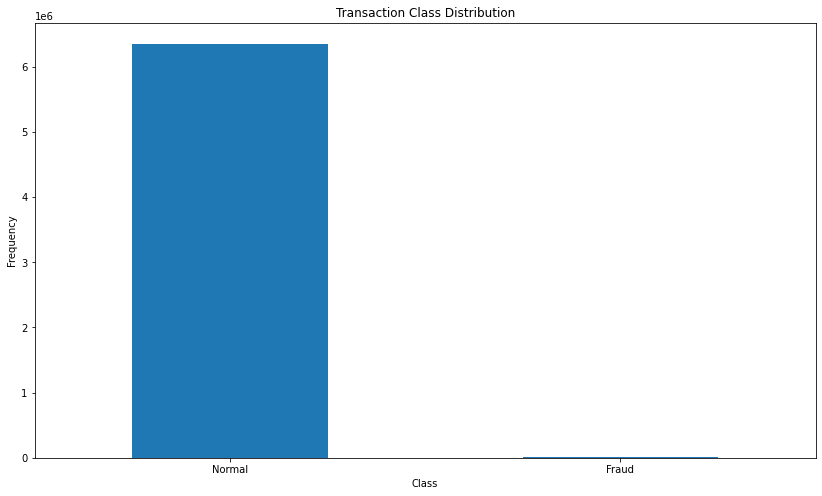

In [8]:
count_classes = pd.value_counts(data['isFraud'], sort = True)

count_classes.plot(kind = 'bar', rot=0)

plt.title("Transaction Class Distribution")

plt.xticks(range(2), LABELS)

plt.xlabel("Class")

plt.ylabel("Frequency")

In [9]:
## Get the Fraud and the normal dataset 

fraud = data[data['isFraud']==1]

normal = data[data['isFraud']==0]

In [10]:
print(fraud.shape,normal.shape)


(8213, 8) (6354407, 8)


In [11]:
## We need to analyze more amount of information from the transaction data
#How different are the amount of money used in different transaction classes?
fraud.amount.describe()


count    8.213000e+03
mean     1.467967e+06
std      2.404253e+06
min      0.000000e+00
25%      1.270913e+05
50%      4.414234e+05
75%      1.517771e+06
max      1.000000e+07
Name: amount, dtype: float64

In [12]:
normal.amount.describe()

count    6.354407e+06
mean     1.781970e+05
std      5.962370e+05
min      1.000000e-02
25%      1.336840e+04
50%      7.468472e+04
75%      2.083648e+05
max      9.244552e+07
Name: amount, dtype: float64

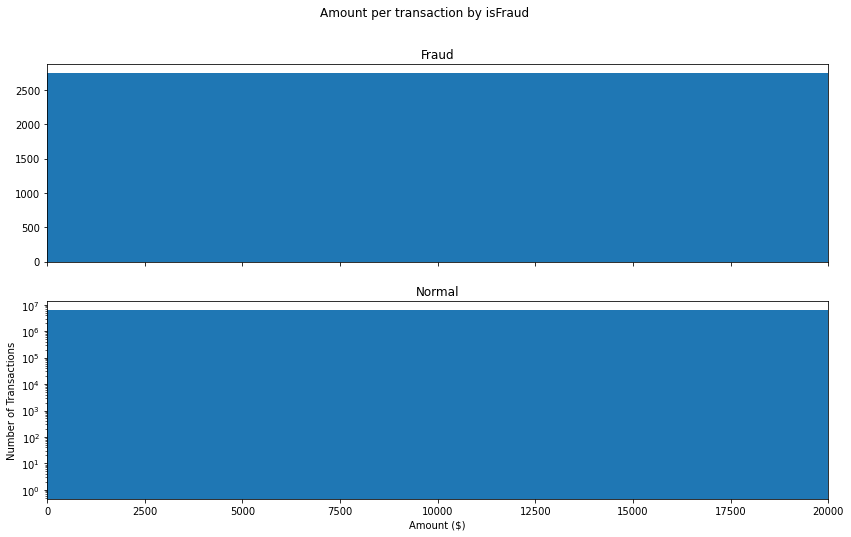

In [13]:
f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('Amount per transaction by isFraud')
bins = 50
ax1.hist(fraud.amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount ($)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))
plt.yscale('log')
plt.show();

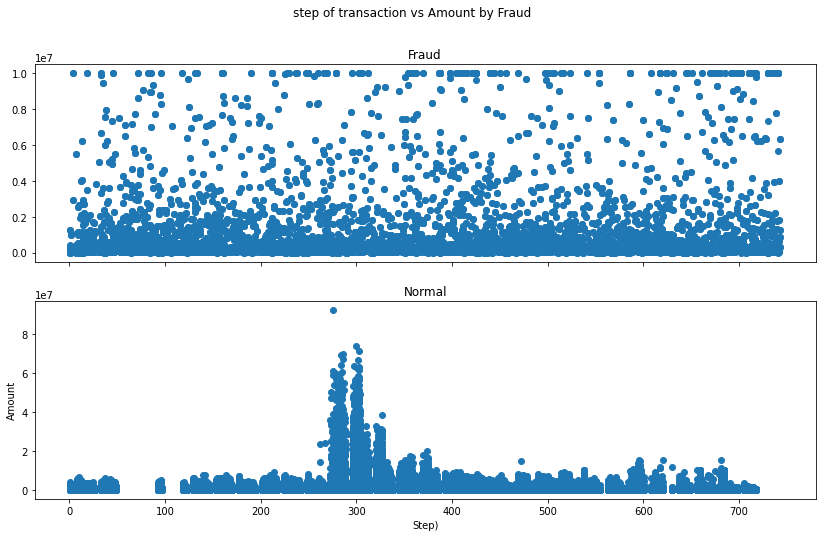

In [14]:
# We Will check Do fraudulent transactions occur more often during certain time frame ? Let us find out with a visual representation.
#1 step = 1 hour

f, (ax1, ax2) = plt.subplots(2, 1, sharex=True)
f.suptitle('step of transaction vs Amount by Fraud')
ax1.scatter(fraud.step, fraud.amount)
ax1.set_title('Fraud')
ax2.scatter(normal.step, normal.amount)
ax2.set_title('Normal')
plt.xlabel('Step)')
plt.ylabel('Amount')
plt.show()

In [15]:
## Take some sample of the data

data1= data.sample(frac = 0.01,random_state=1)

data1.shape

(63626, 8)

In [16]:
data.shape

(6362620, 8)

In [17]:
#Determine the number of fraud and valid transactions in the dataset

Fraud = data1[data1['isFraud']==1]

Valid = data1[data1['isFraud']==0]

outlier_fraction = len(Fraud)/float(len(Valid))

In [18]:
print(outlier_fraction)

print("Fraud Cases : {}".format(len(Fraud)))

print("Valid Cases : {}".format(len(Valid)))


0.0014165197683203223
Fraud Cases : 90
Valid Cases : 63536


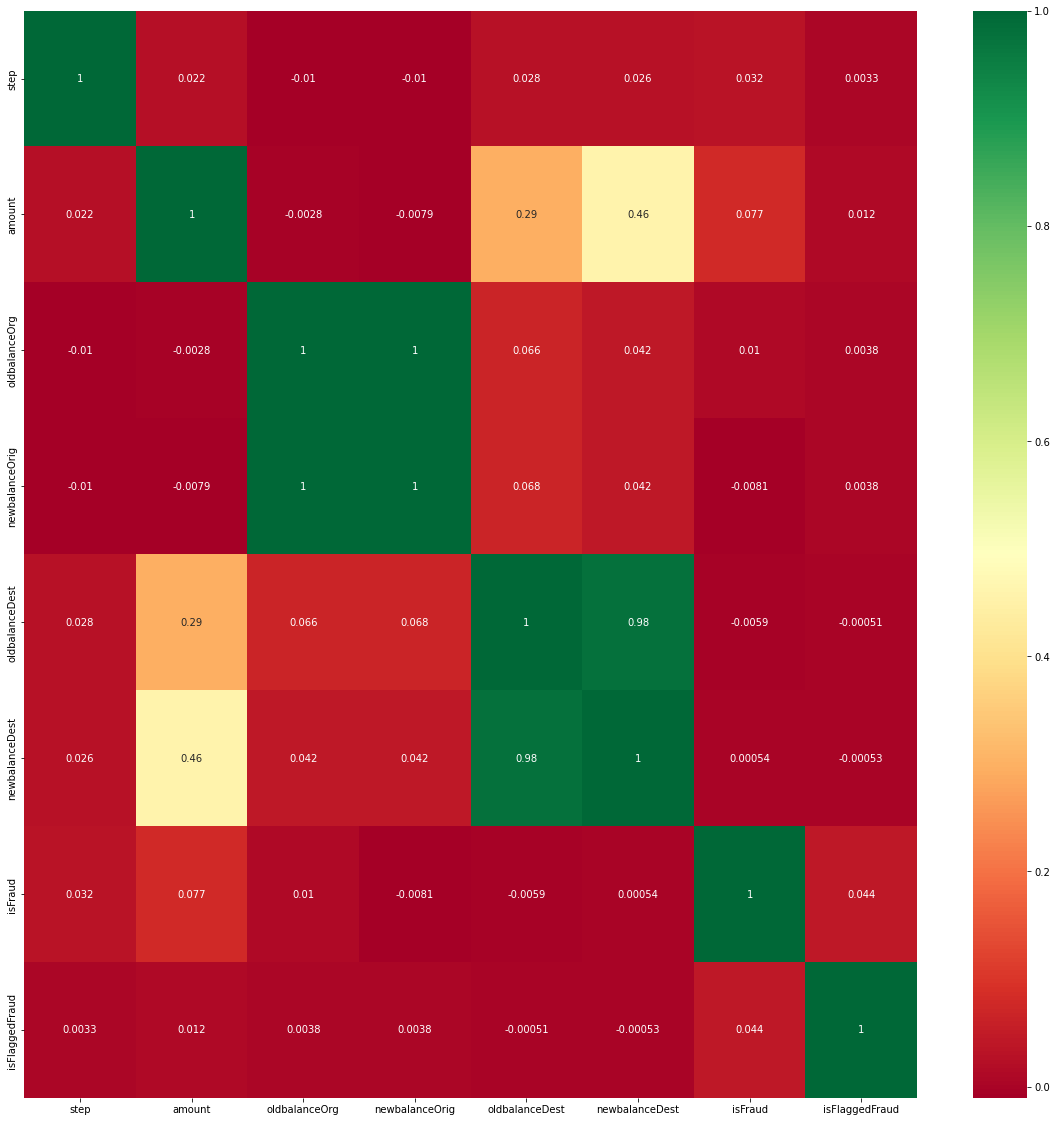

In [19]:
## Correlation
import seaborn as sns
#get correlations of each features in dataset
corrmat = data1.corr()
top_corr_features = corrmat.index
plt.figure(figsize=(20,20))
#plot heat map
g=sns.heatmap(data[top_corr_features].corr(),annot=True,cmap="RdYlGn")

In [20]:
#Create independent and Dependent Features
columns = data1.columns.tolist()
# Filter the columns to remove data we do not want 
columns = [c for c in columns if c not in ["isFraud"]]
# Store the variable we are predicting 
target = "isFraud"
# Define a random state 
state = np.random.RandomState(42)
X = data1[columns]
Y = data1[target]
X_outliers = state.uniform(low=0, high=1, size=(X.shape[0], X.shape[1]))
# Print the shapes of X & Y
print(X.shape)
print(Y.shape)

(63626, 7)
(63626,)


In [21]:
##Define the outlier detection methods

classifiers = {
    "Isolation Forest":IsolationForest(n_estimators=100, max_samples=len(X), 
                                       contamination=outlier_fraction,random_state=state, verbose=0),
    "Local Outlier Factor":LocalOutlierFactor(n_neighbors=20, algorithm='auto', 
                                              leaf_size=30, metric='minkowski',
                                              p=2, metric_params=None, contamination=outlier_fraction),
    "Support Vector Machine":OneClassSVM(kernel='rbf', degree=3, gamma=0.1,nu=0.05, 
                                         max_iter=-1)
   
}

In [22]:
type(classifiers)

dict

In [ ]:
n_outliers = len(Fraud)
for i, (clf_name,clf) in enumerate(classifiers.items()):
    #Fit the data and tag outliers
    if clf_name == "Local Outlier Factor":
        y_pred = clf.fit_predict(X)
        scores_prediction = clf.negative_outlier_factor_
    elif clf_name == "Support Vector Machine":
        clf.fit(X)
        y_pred = clf.predict(X)
    else:    
        clf.fit(X)
        scores_prediction = clf.decision_function(X)
        y_pred = clf.predict(X)
    #Reshape the prediction values to 0 for Valid transactions , 1 for Fraud transactions
    y_pred[y_pred == 1] = 0
    y_pred[y_pred == -1] = 1
    n_errors = (y_pred != Y).sum()
    # Run Classification Metrics
    print("{}: {}".format(clf_name,n_errors))
    print("Accuracy Score :")
    print(accuracy_score(Y,y_pred))
    print("Classification Report :")
    print(classification_report(Y,y_pred))

c:\users\madhuresh\appdata\local\programs\python\python39\lib\site-packages\sklearn\base.py:450: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(


Isolation Forest: 173
Accuracy Score :
0.9972809857605381
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63536
           1       0.04      0.04      0.04        90

    accuracy                           1.00     63626
   macro avg       0.52      0.52      0.52     63626
weighted avg       1.00      1.00      1.00     63626

Local Outlier Factor: 173
Accuracy Score :
0.9972809857605381
Classification Report :
              precision    recall  f1-score   support

           0       1.00      1.00      1.00     63536
           1       0.04      0.04      0.04        90

    accuracy                           1.00     63626
   macro avg       0.52      0.52      0.52     63626
weighted avg       1.00      1.00      1.00     63626

